In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

from BFGS import BFGS
from CG import *
from wolfe import wolfe_bisection


%matplotlib widget

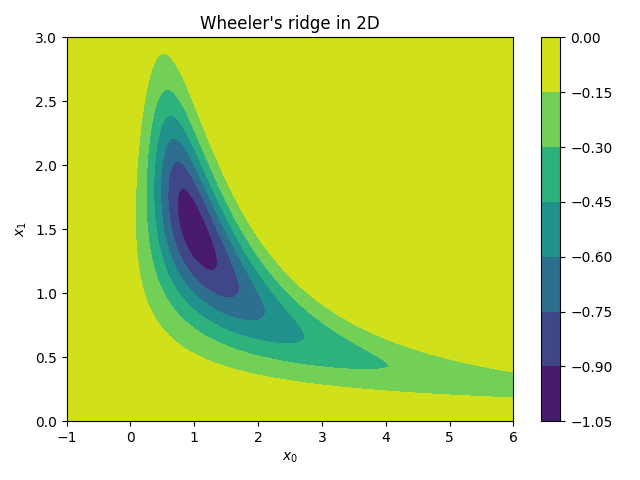

In [3]:
#define wheeler's ridge grad and hessian

def wheelerridge(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    return -np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) # + (x0**2 + x1**2)*1e-4

def g(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    g_x0 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*(x0*x1 - 3/2)*x1 
    g_x1 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*((x0*x1 - 3/2)*x0 + (x1 - 3/2)) 
    return np.array([[g_x0], [g_x1]])

def Hes(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    H00 = -x1**2*(4*x0**2*x1**2 - 12*x0*x1 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    H01 = -((4*x0**3 + 4*x0)*x1**3 + (-12*x0**2 - 6*x0 - 6)*x1**2 + (5*x0 + 9)*x1 + 3)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)
    H11 = -((4*x0**2 + 8*x0**2 + 4)*x1**2 + (-12*x0**3 - 12*x0**2 - 12*x0 - 12)*x1 + 7*x0**2 + 18*x0 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    
    return(np.array([[H00, H01], [H01, H11]]))

x = np.linspace(-1,6, 100)
y = np.linspace(0,3, 100)

XX, YY = np.meshgrid(x, y)
Z = np.zeros_like(XX.flatten())
for i, (X, Y) in enumerate(zip(XX.flatten(), YY.flatten())):
    Z[i] = wheelerridge(np.array([X,Y]))

Z = Z.reshape(XX.shape)

fig, ax = plt.subplots(layout='tight')

cont = ax.contourf(XX, YY, Z)
fig.colorbar(cont)

ax.set(title='Wheeler\'s ridge in 2D', xlabel=r'$x_0$', ylabel=r'$x_1$')

plt.show()

In [5]:
def sim(x):
    return -1*np.exp(-1*((x[0]*x[1]-1.5)**2 + (x[1]-1.5)**2))

def der_sim(x):
    f = sim(x)
    f1 = -2*(x[0]*x[1]-1.5)*x[1]
    f2 = -2*(x[0]*x[1]-1.5)*x[0] -2*(x[1]-1.5)
    return np.array([f*f1, f*f2])

def wheelerridge_md(x):

    x = x.reshape(-1, 1)
    y = np.zeros(x.shape)
    y[:-1] = x[:-1]*x[1:]
    y[-1] = x[-1]
    return -1*np.exp(-1*sla.norm(y-1.5, 2)**2)

def der_wheelerridge_md(x):

    fval = wheelerridge_md(x)
    d = x.shape[0]
    der = np.zeros(x.shape)
    der[0] = -2*(x[0]*x[1]-1.5)*x[1]
    der[-1] = -2*(x[-2]*x[-1]-1.5)*x[-2] + -2*(x[-1]-1.5)
    for i in range(1, d-1):
        der[i] = -2*(x[i-1]*x[i]-1.5)*x[i-1] -2*(x[i]*x[i+1]-1.5)*x[i+1]
    der = fval*der
    der = der.reshape(-1, 1)
    return der

def Hess_wheelerridge_md(x):

    






x = np.array([1.4, 1.2])
print(sim(x), der_sim(x))
print(wheelerridge(x), g(x).T)
print(wheelerridge_md(x), der_wheelerridge_md(x).T)
x = np.array([1.2, 1.2, 1.5])
print(wheelerridge_md(x), der_wheelerridge_md(x).T)


-0.8847943799576549 [ 0.38223117 -0.08494026]
-0.8847943799576549 [[ 0.38223117 -0.08494026]]
-0.8847943799576549 [[ 0.38223117 -0.08494026]]
-0.910646948177995 [[-0.13113316  0.68844909  0.6556658 ]]


In [11]:
x0 = np.array([1, 1, 1.3])
x, grads, obj_calls = CG(x0, wheelerridge_md, der_wheelerridge_md, get_step=wolfe_bisection, kmax=100, option=0, verbose=False)
print(x.T)

[[1.50009077 0.9999523  1.50003999]]


[[1.6406917 ]
 [2.06591742]]
[[1.  1.5]] [[1.  1.5]]


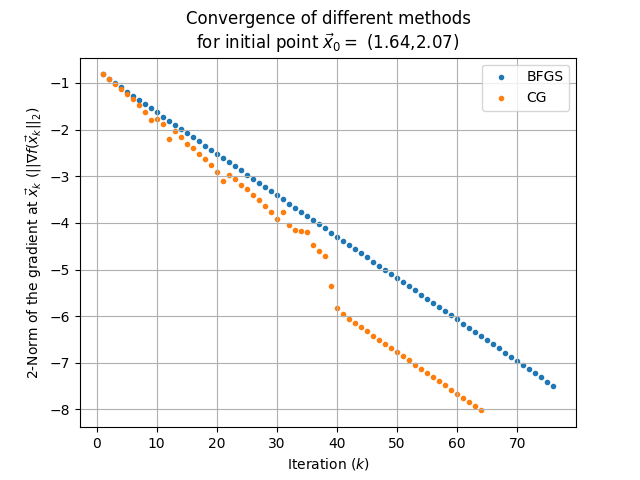

In [6]:
##Test a random point for BFGS and CG x in [0.5,3], y in [0,3]

x0 = np.random.random((2,1)).reshape(-1,1)*np.array([[2.5],[3]]) + np.array([[0.5],[0]])
print(x0)
H = sla.inv(Hes(x0))
eigs = sla.eigvals(H)
if np.any(eigs <= 0 ): H = H - np.min(eigs)*1.1*np.eye(2,2)
sla.eigvals(H)

x, grads, _ = BFGS(x0, wheelerridge, H=H, get_step=wolfe_bisection, 
                   verbose=False, eps=1e-8, kmax=1000, gmethod=1)
x_CG, grads_CG, _ = CG(x0, wheelerridge_md, der_wheelerridge_md, get_step=wolfe_bisection, 
                       eps=1e-8, kmax=1000, gmethod=0)

fig, ax = plt.subplots()
print(x.T, x_CG.T)
ax.scatter(np.arange(1,len(grads)+1), np.log10(grads), marker='.', label='BFGS')
ax.scatter(np.arange(1,len(grads_CG)+1), np.log10(grads_CG), marker='.', label='CG')
ax.grid()
ax.legend()
ax.set(xlabel=r'Iteration ($k$)', 
       ylabel=r'2-Norm of the gradient at $\vec{x}_k$ ($||\nabla f(\vec{x}_k||_2$)',
       title='Convergence of different methods\n' + r'for initial point $\vec{x}_0 =$ ' + f'({x0[0,0]:.2f},{x0[1,0]:.2f})')

plt.show()

In [23]:
#Testing BFGS
its = []
f_calls = []
N = 200
for i in range(N):
    x0 = np.random.random((2,1)).reshape(-1,1)*np.array([[2.5],[3]]) + np.array([[0.5],[0]])

    H = sla.inv(Hes(x0))
    eigs = sla.eigvals(H)
    if np.any(eigs <= 0 ): H = H - np.min(eigs)*1.1*np.eye(2,2)
    sla.eigvals(H)

    x, grads, obj_calls = BFGS(x0, wheelerridge, g, H, get_step=wolfe_bisection, 
                   verbose=False, eps=1e-8, kmax=100)
    
    if sla.norm(x - np.array([[1],[1.5]])) < 0.01:
        its.append(len(grads))
        f_calls.append(obj_calls)

its = np.array(its)
f_calls = np.array(f_calls)

print('stats for BFGS:') 
print('number of iterations...')
print(f'mean: {np.mean(its):.0f}')
print(f'max: {np.max(its)}')
print(f'min: {np.min(its)}')

print()

print('number of function calls...')
print(f'mean: {np.mean(f_calls):.0f}')
print(f'max: {np.max(f_calls)}')
print(f'min: {np.min(f_calls)}')

print(f'number of converged runs: {its.size}/{N}')

stats for BFGS:
number of iterations...
mean: 86
max: 100
min: 76

number of function calls...
mean: 174
max: 201
min: 153
number of converged runs: 200/200


In [12]:
#Testing Conj. Grad.
its = []
f_calls = []
N = 200
for i in range(N):
    x0 = np.random.random((3,1)).reshape(-1,1)*np.array([[2.5],[2.5],[3]]) + np.array([[0.5],[0.5],[0]])

    x, grads, obj_calls = CG(x0, wheelerridge_md, der_wheelerridge_md, get_step=wolfe_bisection, kmax=1000, option=0)
    
    if sla.norm(x - np.array([[1.5],[1],[1.5]])) < 0.01:
        its.append(len(grads))
        f_calls.append(obj_calls)

its = np.array(its)
f_calls = np.array(f_calls)

print('stats for Conj. Grad.')
print('number of iterations...')
print(f'mean: {np.mean(its):.0f}')
print(f'max: {np.max(its)}')
print(f'min: {np.min(its)}')

print()

print('number of function calls...')
print(f'mean: {np.mean(f_calls):.0f}')
print(f'max: {np.max(f_calls)}')
print(f'min: {np.min(f_calls)}')

print(f'number of converged runs: {its.size}/{N}')

stats for Conj. Grad.
number of iterations...
mean: 41
max: 66
min: 18

number of function calls...
mean: 83
max: 133
min: 37
number of converged runs: 200/200
